In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 39.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataframe = pd.read_csv('/content/drive/My Drive/Applied AI/quality_annotated_dataframe.csv')

In [ ]:
!unzip "/content/drive/MyDrive/Applied AI/train.zip" -d "/content/train/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/P/P03803_1.jpeg  
  inflating: /content/train/P/P03803_2.jpeg  
  inflating: /content/train/P/P03804_1.jpeg  
  inflating: /content/train/P/P03809_1.jpeg  
  inflating: /content/train/P/P03809_2.jpeg  
  inflating: /content/train/P/P03811_1.jpeg  
  inflating: /content/train/P/P03811_2.jpeg  
  inflating: /content/train/P/P03813_1.jpeg  
  inflating: /content/train/P/P03814_1.jpeg  
  inflating: /content/train/P/P03814_2.jpeg  
  inflating: /content/train/P/P03815_1.jpeg  
  inflating: /content/train/P/P03817_1.jpeg  
  inflating: /content/train/P/P03817_2.jpeg  
  inflating: /content/train/P/P03821_1.jpeg  
  inflating: /content/train/P/P03821_2.jpeg  
  inflating: /content/train/P/P03828_1.jpeg  
  inflating: /content/train/P/P03828_2.jpeg  
  inflating: /content/train/P/P03830_1.jpeg  
  inflating: /content/train/P/P03831_1.jpeg  
  inflating: /content/train/P/P03838_1.jpeg  
  inflating: /content/train/P

In [ ]:
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/content/train/' + dataframe_path['label'] + '/' + dataframe_path['file']

Removed 1293 duplicates


In [ ]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    
    gaussian_img = np.stack([gaussian_img for i in range(3)], axis=-1)
    
    scaled = tf.keras.applications.densenet.preprocess_input(gaussian_img)
    
    return scaled

In [ ]:
def preprocessing_scratch(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    
    # Rescale to float between 0 and 1
    rescaled = np.float32(gaussian_img) / 255.
    rescaled = np.reshape(rescaled, (1,512,512,1))

    return rescaled

In [ ]:
!unzip "/content/Q-DenseNet169-MedModel-UltimatePerformance_expanded.zip" -d "/content/MedModel/"

unzip:  cannot find or open /content/Q-DenseNet169-MedModel-UltimatePerformance_expanded.zip, /content/Q-DenseNet169-MedModel-UltimatePerformance_expanded.zip.zip or /content/Q-DenseNet169-MedModel-UltimatePerformance_expanded.zip.ZIP.


In [ ]:
densenet_model = keras.models.load_model("/content/MedModel/kaggle/working/Q-DenseNet169-MedModel-UltimatePerformance_expanded")

OSError: ignored

In [ ]:
!unzip "/content/QualityScratchMedModel.zip" -d "/content/MedModelScratch/"

Archive:  /content/QualityScratchMedModel.zip
   creating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/
  inflating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/saved_model.pb  
  inflating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/keras_metadata.pb  
 extracting: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/fingerprint.pb  
   creating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/assets/
   creating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/variables/
  inflating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/variables/variables.data-00000-of-00001  
  inflating: /content/MedModelScratch/kaggle/working/QualityScratchMedModel/variables/variables.index  


In [ ]:
scratch_model = keras.models.load_model('/content/MedModelScratch/kaggle/working/QualityScratchMedModel')

In [ ]:
# Choose model for gradcam
is_densenet = False

if is_densenet:
  model = densenet_model
  gradcam_layer = 'conv5_block16_concat'
else:
  model = scratch_model
  gradcam_layer = 'conv2d_20'


In [ ]:
if is_densenet:
  test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
else:
  test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_scratch)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_path,
    directory='content/train/',
    x_col='path',
    y_col='label',
    classes=['N', 'P', 'T'],
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    data_format="channels_last",
    color_mode='rgb' if is_densenet else 'grayscale',
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 10792 validated image filenames belonging to 3 classes.


In [ ]:
predictions = model.predict(test_generator)

169/169 [==============================] - 216s 1s/step


In [ ]:
label_dict = {'N':0, 'P':1, 'T':2}
numerical_dict = {0:'N', 1:'P', 2:'T'}
dict_apply = lambda x: label_dict[x]

true_labels = dataframe_path['label'].apply(dict_apply).to_numpy()
prediction_numerical = np.argmax(predictions, axis=-1)
correct_predictions = np.array(np.where(prediction_numerical == true_labels)).flatten()
incorrect_predictions = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions)

In [ ]:
prediction_numerical = np.argmax(predictions, axis=-1)
correct_predictions = np.array(np.where(prediction_numerical == true_labels)).flatten()
incorrect_predictions = np.setdiff1d(np.arange(0, true_labels.shape[0]), correct_predictions)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 512, 512, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 256, 256, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 128)     

In [ ]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model


    Args:
    model: tf model
    img_array: (img_width x img_width) numpy array
    layer_name: str


    Returns 
    uint8 numpy array with shape (img_height, img_width)

    '''


    # Load the model and extract the last convolutional layer and the dense layer
    last_conv_layer = model.get_layer(layer_name)

    gradModel = keras.Model(inputs=model.inputs, 
              outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32) #we use the preprocessed image
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap,predictions


In [ ]:
def light_preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    
    # Rescale to float between 0 and 1
    rescaled = np.float32(gaussian_img) / 255.

    return rescaled

In [ ]:
def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def display_gradcam(img, heatmap):
    # Load the original image

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

    #heatmap = sigmoid(heatmap, 50, thresh, 1)

    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    fig, axs = plt.subplots(1, 3, figsize=(21,12))
    
    # Display Grad CAM
    axs[0].imshow(img)
    axs[1].imshow(light_preprocessing(img), cmap='gray')
    axs[2].imshow(superimposed_img)


In [ ]:
paths = dataframe_path['path'].to_numpy()

In [ ]:
import random

In [ ]:
correct_predictions.shape

(10417,)

In [ ]:
desired_class = 1
bag_of_examples = np.array(np.where(true_labels == desired_class)).flatten()
bag_of_examples = np.intersect1d(bag_of_examples, correct_predictions)

Current Prediction: 1955, Predicted: 0, Correct: 0


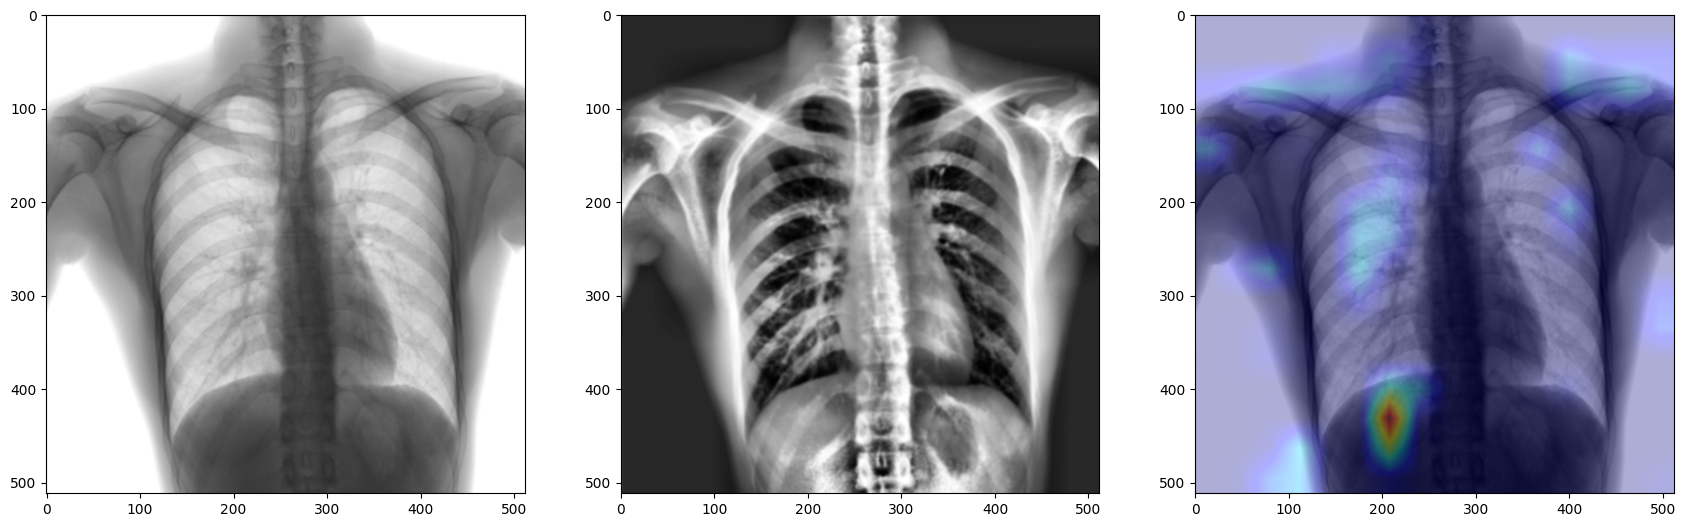

In [ ]:
current_prediction = 1955#np.random.choice(bag_of_examples, 1)[0]
current_image = cv2.imread(paths[current_prediction], cv2.IMREAD_GRAYSCALE)
if is_densenet:
  processed = preprocessing(current_image)
  processed = cv2.resize(processed, (512,512))
  processed = np.reshape(processed, (1,512,512,3))
else:
  processed = cv2.resize(current_image, (512,512))
  processed = preprocessing_scratch(processed)

grad_cam,predictions=GradCam(model,processed,gradcam_layer)

original_image = cv2.resize(current_image, (512,512))
original_image = np.stack([original_image for i in range(3)], axis=-1)
print('Current Prediction: {}, Predicted: {}, Correct: {}'.format(current_prediction, prediction_numerical[current_prediction], true_labels[current_prediction]))
display_gradcam(original_image, grad_cam)

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import lime
import lime.lime_image
from tensorflow.keras.preprocessing import image

In [ ]:
# Define a function that takes in an input image and returns the predicted class probabilities
def predict_fn(current_batch):
  if is_densenet:
    processed = np.empty((current_batch.shape[0],512,512,3))
    for batch_k in range(current_batch.shape[0]):
      buff = cv2.resize(current_batch[batch_k], (512,512))
      processed[batch_k, :, :, :] = preprocessing(buff)
  else:
    processed = np.empty((current_batch.shape[0],512,512,1))
    for batch_k in range(current_batch.shape[0]):
      buff = cv2.resize(current_batch[batch_k], (512,512))
      processed[batch_k, :, :, :] = preprocessing_scratch(buff)
  preds = model.predict(processed)
  return preds

# Load the current prediction to explain
current_image = cv2.imread(paths[current_prediction], cv2.IMREAD_GRAYSCALE)

# Create an ImageExplainer
explainer = lime.lime_image.LimeImageExplainer()

# Generate an explanation for the input image
explanation = explainer.explain_instance(np.array(current_image),
                                         classifier_fn=predict_fn,
                                         top_labels=3,
                                         hide_color=0,
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


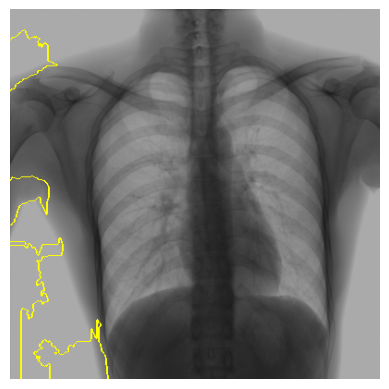

In [ ]:
from skimage.segmentation import mark_boundaries
from PIL import ImageEnhance
# Display the explanation in a Jupyter notebook
fig, ax = plt.subplots()
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp = temp /255.
ax.imshow(mark_boundaries(temp / 1.5, mask))

plt.axis('off')
plt.show()